# Homogeneous response

It's now time to [move it](https://www.youtube.com/watch?v=hdcTmpvDO0I). We want to simulate how Turbie responds to a provided set of initial conditions.

To solve for a time-marching response, we will use numerical integrators that can solve dynamical systems of the form  
\begin{equation}
    \overline{y}'(t) = f(t, \overline{y}).
\end{equation}
Thus, there are two steps:  
 1. Create a function called `dydt` that calculates $\overline{y}'(t)$ given $t$ and $y$.  
 2. Pass that function into a numerical solver, which will output the response. 
 
Let's consider a homogeneous dynamical system of the form  
\begin{equation}
[M]\ddot{\overline{x}}(t) + [C]\dot{\overline{x}}(t) + [K]\overline{x}(t) = \overline{0},
\end{equation}
and define a new vector $\overline{y}(t)=[\overline{x}(t),\dot{\overline{x}}(t)]^T$, called a state vector. In this case, it can be shown (proof left to the reader) that  
\begin{equation}
    \overline{y}'(t) = \left[ \begin{array}{cc}   [0]_{N\times N} & [I]_{N\times N} \\
                         -[M]^{-1}[K] & -[M]^{-1}[C] 
        \end{array}\right]
        \overline{y}(t) + [0] \\
\end{equation}
where $N$ is the number of degrees of freedom. For Turbie, $N=2$. We can simplify this expression as  
\begin{equation}
    \overline{y}'(t) = [A]\overline{y}(t) 
\end{equation}

If you have a function that calculates the derivative of your dynamical system, then you can use a numerical solver such as `scipy.integrate.solve_ivp` or Matlab's `ode45` to simulate the system.

### Exercises for the reader

1. For Turbie, what are the dimensions of $\overline{y}(t)$? Of matrix $[A]$? Of $\overline{y}'(t)$?  
2. Let's say $\overline{y}(t=t_p)=[0.4, -1.2, 10.4, 3.5]$. What is the blade deflection at $t=t_p$? What is the tower velocity?  
3. Create a function called $dydt$ that takes as input a scalar $t$ and an array $y$ and returns $\overline{y}'(t)$ for Turbie when $\overline{F}(t)=0$. What is the value of `dydt` when $t=1$ and $y=[1, 2, 3, 4]$?  
4. Look at the documentation for `scipy.integrate.solve_ivp` or `ode45`. Define all the input variables you will need to use the function.
5. Use `scipy.integrate.solve_ivp` or `ode45` to simulate Turbie's response when $\overline{F}(t)=0$ for the settings below. What is the shape of `y`? What do the rows/columns represent?  
   * Time vector spans from 0 to 60 in spaces of 0.01 s.  
   * Turbie initial conditions are `y = [1, 0, 0, ]`.  
6. Plot the **RELATIVE** blade deflection and tower deflection versus time in the same plot. Be careful, remember that the solution to `dydt` yields the absolute displacements and velocities!  
7. **Optional!** Run with different initial conditions, and compare the PSD with different initial conditions. What do you see? Can you theorize why certain initial conditions might affect different peaks? (Requires dynamics background, but a hint is mode shapes...)


**Notes!**  
 * Matlab users may pass in their time vector directly to `tspan`. Python users, `tspan` must be a list of two numbers, `tspan = [t0, ft]`, so you must use the keyword argument `t_eval` to evaluate at specific time steps.  
 * There are two ways to handle the system matrices. You can either create them as global variables in the script, or you include them as inputs to `dydt` and (1) use the `args` paramter for `solve_ivp` in Python or (2) create an anonymous function in Matlab (see `ode45` docs).  
 * The `solve_ivp` function returns a dictionary with a lot of information. You are only interested in the `t` and `y` values, so you can extract them as follows:  
```python
res = solve_ivp(dydt, tspan, y0, t_eval=t_eval)  # solve time-marching problem
t, y = res['t'], res['y']  # extract time and response
```  
 * To import `solve_ivp`, you can either do `import scipy.integrate` followed by `scipy.integrate.solve_ivp` OR you can say `from scipy.integrate import solve_ivp`. 

### Answers to the exercises

#### Exercise 1

The $y$ array is 4 elements long, twice the number of our degrees of freedom. Those elements correspond to blade deflection, tower deflection, blade velocity, and tower velocity. Matrix $[A]$ is a 4x4 array. Array $\overline{y}'(t)$ is also 4 elements long.

#### Exercise 2

The blade deflection is 0.4, the first element. The tower velocity is 3.5, the last element.

#### Exercise 3

In [1]:
import numpy as np
from turbie import get_turbie_system_matrices


def dydt(t, y, M, C, K):
    """Differential function for Turbie (no forcing)"""
    Minv = np.linalg.inv(M)  # save inverse
    ndof = M.shape[0]  # get number of degrees of freedon
    # assemble matrix A
    I, O = np.eye(ndof), np.zeros((ndof, ndof))
    A = np.block([[O, I], [-Minv @ K, -Minv @ C]])
    # define forcing
    F = np.zeros(ndof)  # forcing is zero for now
    # assemble array B
    B = np.zeros(2*ndof)  # initialize the array
    B[ndof:] = Minv @ F
    return A @ y + B

# load system matrices
M, C, K = get_turbie_system_matrices()

# test the function
t_test, y_test = 1, [1, 2, 3, 4]
print(dydt(t_test, y_test, M, C, K))

[ 3.          4.         13.94478049 -7.05863274]


#### Exercise 4

In [2]:
from scipy.integrate import solve_ivp

# define our time vector
t0, tf, dt = 0, 60, 0.01

# inputs to solve ivp
tspan = [t0, tf]  # 2-element list of start, stop
y0 = [1, 0, 0, 0]  # initial condition
t_eval = np.arange(t0, tf, dt)  # times at which we want output
args = (M, C, K)  # extra arguments given to dydt

#### Exercise 5

In [5]:
# run the numerical solver
res = solve_ivp(dydt, tspan, y0, t_eval=t_eval, args=args)

# extract the output
t, y = res.t, res.y

y.shape  # print shape

(4, 6000)

The shape of `y` is 4 by 6000. Each row corresponds to a different element in the state vector (blade deflection, tower deflection, blade velocity, and tower velocity), and each column is a different time step.

#### Exercise 6

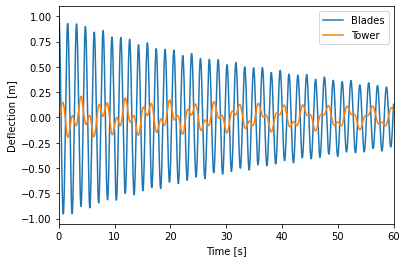

In [8]:
import matplotlib.pyplot as plt

# extract data from y
xb = y[0, :] - y[1, :]
xt = y[1, :]

# make the plot
plt.plot(t, xb, label='Blades')
plt.plot(t, xt, label='Tower')
plt.xlim(tspan)
plt.xlabel('Time [s]')
plt.ylabel('Deflection [m]')
plt.legend();